# Importing Libraries and Cleaned Datasets

In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

county_health_rank = pd.read_csv('county_rankings25.csv')
qol_22 = pd.read_csv('QOL.csv')
gini = pd.read_csv('gini_index.csv')
fips_codes = pd.read_csv('all_fips.csv')
county_vars = pd.read_csv('county_vars_2.csv')
race_groups = pd.read_csv('agg_race_variables.csv')

# Data Cleaning Plan
## County Health Rankings 2025
In place of the previousl 4 tables reporting socio economic metrics, I found a new Dataset 'County Health Rankings.' The data wrangling process will involve selecting the target variables, renaming, normalizing data types, validating the resulting dataframe, and applying the standardized hierarchical index (county, state).

Since dataset contains hundreds of variables, I created a small dataframe of our variables of interest and normalized names to facilate creating the subset itself and its naming conventions. 

Note: much of the numeric data is in percentages, separate subsets will include totals and percentages and will be used depnding on type of analysis and indexing needed.

## FIPS & States ID table
I will merge both tables above to a previosly created 'all_fips' (which serves as a sort of  'fact table'-listing county names, state names, state abbreviations, and corresponding fips codes) by index. 

I will validate the data and clean any merging errors like the creation of duplicate columns and/or changes to naming conventions (such as adding suffixes/prefixes to duplicate and original colums).

Finally, I will merge both of these new tables by the standardized index mentioned above.

# Data Cleaning

## County Rankings tables

### Make SUbset Function

In [ ]:
# defining variable for function to select target vars, dictionary to rename, and set 'fips' as 'str' dtype
county_health_subset = county_vars['raw_variable'].tolist()
county_name_list = county_vars[' new_name'].tolist()
county_new_names = dict(zip(county_health_subset, county_name_list))

In [ ]:
def make_subset(df, target_vars, target_names):
    df = df[target_vars]
    df = df.rename(columns=target_names) #dictionary defined from target variables & names list
    df['fips'] = df['fips'].astype('str')
    return df


In [ ]:
counties = make_subset(county_health_rank, county_health_subset, county_new_names)

### Clean colums function

In [176]:
# list of state names from master fips to drop from county namers column
state_names = fips_codes['state'].unique()
state_names = state_names.tolist()
state_names.append('United States')
# variable name referring to state 


In [177]:
def clean_subset(df):
    df = df[~df['county'].isin(state_names)]
    df = df.round(2)
    return df


In [178]:
counties = clean_subset(counties)

## Gini

In [179]:
gini_target_vars = ['fips', 'county', 'state', 'gini_index']
gini_new_names = {'gini_index':'gini_ind'}

In [180]:
gini = make_subset(gini, gini_target_vars, gini_new_names)
gini = clean_subset(gini)

### QOL

In [181]:
qol_target_vars = ['2020PopulrVoteParty', 'NMCNTY', 'FIPS', 'LSTATE']
qol_new_names = {'2020PopulrVoteParty': 'political_party', 'NMCNTY':'county', 'FIPS':'fips', 'LSTATE':'state_abbr'}

In [182]:
pol_party_2020 = make_subset(qol_22, qol_target_vars, qol_new_names)

## subsets and groupings for drill-down analysis 

## Variable-based subsets

### Inequity Metrics

In [185]:
inequity_vars = ['state_abbr','county','fips', 'income_inequality', 'gender_pay_gap', 'school_segration_index', 'residential_segregation','school_funding_gap', 'gini_ind']
#inequity_df = counties[inequity_vars]

### Socio-economic indicators with racial breakdown

In [186]:
racial_category_subset = race_groups['raw_variable'].tolist()
racial_category_names = race_groups['new_name'].tolist()
racial_category_cols = dict(zip(racial_category_subset, racial_category_names))

In [187]:
race_subset = make_subset(county_health_rank, racial_category_subset, racial_category_cols)
counties_race = clean_subset(race_subset)

In [188]:
# reshape dataframe
# Melt the dataframe to long format
counties_race = counties_race.melt(
    id_vars=['state_abbr', 'county', 'fips', 'county_population'], 
    var_name='metric_race', 
    value_name='value'
)

# Split the combined 'metric_ethnicity' column
counties_race[['metric', 'race']] = counties_race['metric_race'].str.extract(r'(.+?)-(.+)')

# Drop the original combined column
counties_race = counties_race.drop(columns='metric_race')

# Pivot to have metrics as columns
counties_race = counties_race.pivot_table(
    index=['state_abbr', 'county', 'fips', 'race', 'county_population'],
    columns='metric',
    values='value'
).reset_index()

# Clean up column names if needed
counties_race.columns.name = None


### County-Level socio-economic outcomes (no racial breakdown)

In [189]:
aggregate_outcomes = counties.drop(columns=['income_inequality', 'gender_pay_gap', 'school_segration_index', 'residential_segregation','school_funding_gap', 'child_mortality', 'child_poverty_percentage', 'firearm_fatalities',
       'life_expectancy', 'median_income', 'premature_death'])

## Total Values (vs percentages)

### Counties 

In [190]:
pop_vars = ['state_abbr','county','fips', 'population']
county_pop = counties[pop_vars]
# find columns w percentage ouputs by assigining target string to variable ans using lamda  func to filter col names and assign to list
percent_str = 'percentage'
percent_vars = list(filter(lambda x: percent_str in x, county_name_list))
counties_totals = counties.copy()
counties_pop_col = 'population'

#### totals function

In [191]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_total_pop(df, cols, pop_col):
    for i in df[cols]:
        df[i] = df[i] * df[pop_col]
    df.columns = df.columns.str.replace('_percentage', '')
    return df


In [192]:
counties_totals= clean_subset(counties_totals)
counties_totals.head()

,index,fips,county,state_abbr,hs_diploma_percentage,unemployed_percentage,population,median_income,school_segration_index,gender_pay_gap,...,school_funding_gap,residential_segregation,premature_death,income_inequality,child_poverty_percentage,life_expectancy,child_mortality,high_housing_cost_percentage,firearm_fatalities,child_care_cost_burden
2,2,1001,Autauga County,AL,0.90,0.02,60342.0,68857.0,0.06,0.71,...,-2319.66,33.96,9938.26,4.27,0.17,74.80,61.26,0.12,17.45,0.22
3,3,1003,Baldwin County,AL,0.92,0.02,253507.0,74248.0,0.09,0.72,...,506.30,42.65,8957.11,4.36,0.14,76.58,50.16,0.10,14.96,0.19
4,4,1005,Barbour County,AL,0.78,0.04,24585.0,45298.0,0.04,0.77,...,-17790.46,22.73,12738.66,5.61,0.35,72.71,71.71,0.10,26.65,0.29
5,5,1007,Bibb County,AL,0.80,0.02,21868.0,56025.0,0.09,0.82,...,-3657.80,40.01,11708.95,5.35,0.21,72.98,87.08,0.09,21.54,0.27
6,6,1009,Blount County,AL,0.83,0.02,59816.0,64962.0,0.09,0.81,...,-1559.42,64.89,11898.09,4.62,0.17,72.94,58.04,0.08,18.14,0.25


### Totals- broken down by race

In [193]:
race_pop_col = 'county_population'
race_percentage_vars = [ 'population_percentage', 'child_poverty_percentage']
racial_breakdown_total = counties_race.copy()

#racial_breakdown_total = racial_breakdown_total.round(2)

In [194]:
counties_race_totals = calc_total_pop(racial_breakdown_total, race_percentage_vars, race_pop_col)

Note: Many missing values

## Merge for Analysis

## Merge with 'fact' table ('all_fips') for uniform id variables

In [ ]:
fips_codes['fips'] = fips_codes['fips'].astype('str')
#test = pd.merge(counties, fips_codes, on=['state_abbr','county', 'fips'], how='outer')
test_gini = pd.merge(gini, fips_codes, on=['state','county', 'fips'], how='outer')
test_pol_party = pd.merge(pol_party_2020, fips_codes, on=['state_abbr','county', 'fips'], how='outer')

In [221]:
# function to clean merged tables
def clean_merged(df):
    df = df.sort_values(['fips'])
    # Drop duplicate rows in column: 'fips'
    df = test.drop_duplicates(subset=['fips'])
    df = df[~df['county'].isin(state_names)]
    df = df.round(3)
    return df


In [241]:
gini_plus= pd.merge(counties, test_gini, on='fips', how='outer')

In [243]:
gini_plus.columns

Index(['index_x', 'fips', 'county_x', 'state_abbr_x',
       'hs_diploma_percentage_x', 'unemployed_percentage_x', 'population_x',
       'median_income_x', 'school_segration_index_x', 'gender_pay_gap_x',
       'uninsured__percentage_x', 'school_funding_gap_x',
       'residential_segregation_x', 'premature_death_x', 'income_inequality_x',
       'child_poverty_percentage_x', 'life_expectancy_x', 'child_mortality_x',
       'high_housing_cost_percentage_x', 'firearm_fatalities_x',
       'child_care_cost_burden_x', 'index_y', 'county_y', 'state_abbr_y',
       'hs_diploma_percentage_y', 'unemployed_percentage_y', 'population_y',
       'median_income_y', 'school_segration_index_y', 'gender_pay_gap_y',
       'uninsured__percentage_y', 'school_funding_gap_y',
       'residential_segregation_y', 'premature_death_y', 'income_inequality_y',
       'child_poverty_percentage_y', 'life_expectancy_y', 'child_mortality_y',
       'high_housing_cost_percentage_y', 'firearm_fatalities_y',
      

In [ ]:
id_cols = ['state','state_abbr','county', 'fips']
#test = clean_merged(test)
test_gini = clean_merged(gini)
test_pol_party = clean_merged(test_pol_party)
test_2 = pd.merge(test, test_gini, on=id_cols, how='outer')
merged_county_level = pd.merge(test_2, test_pol_party, on=id_cols, how='outer')

In [233]:
test_gini.head()

,index,fips,county,state_abbr,hs_diploma_percentage,unemployed_percentage,population,median_income,school_segration_index,gender_pay_gap,...,residential_segregation,premature_death,income_inequality,child_poverty_percentage,life_expectancy,child_mortality,high_housing_cost_percentage,firearm_fatalities,child_care_cost_burden,state
0,70.0,2013,Aleutians East Borough,AK,0.84,0.02,3461.0,83000.0,NaN,1.07,...,NaN,4200.34,4.73,0.19,NaN,NaN,0.09,NaN,0.22,Alaska
1,71.0,2016,Aleutians West Census Area,AK,0.90,0.03,5160.0,104159.0,0.20,0.71,...,NaN,5785.40,3.13,0.05,85.92,NaN,0.04,NaN,0.31,Alaska
2,72.0,2020,Anchorage Borough,AK,0.94,0.03,286075.0,93881.0,0.10,0.87,...,47.18,9853.06,4.05,0.10,76.34,63.38,0.12,19.28,0.38,NaN
4,73.0,2050,Bethel Census Area,AK,0.82,0.10,18224.0,62140.0,0.23,1.22,...,14.94,18066.47,5.55,0.36,68.86,200.49,0.09,38.10,0.40,Alaska
5,74.0,2060,Bristol Bay Borough,AK,0.95,0.04,844.0,99790.0,NaN,0.94,...,NaN,16587.52,3.60,0.18,NaN,NaN,0.04,NaN,0.23,Alaska


### clean merge result

In [224]:
merged_county_level.head()

,county,state_abbr,state,index,hs_diploma_percentage,unemployed_percentage,population,median_income,school_segration_index,gender_pay_gap,...,school_funding_gap,residential_segregation,premature_death,income_inequality,child_poverty_percentage,life_expectancy,child_mortality,high_housing_cost_percentage,firearm_fatalities,child_care_cost_burden
fips,,,,,,,,,,,,,,,,,,,,,
1001,Autauga County,AL,Alabama,2.0,0.90,0.02,60342.0,68857.0,0.06,0.71,...,-2319.66,33.96,9938.26,4.27,0.17,74.80,61.26,0.12,17.45,0.22
1003,Baldwin County,AL,Alabama,3.0,0.92,0.02,253507.0,74248.0,0.09,0.72,...,506.30,42.65,8957.11,4.36,0.14,76.58,50.16,0.10,14.96,0.19
1005,Barbour County,AL,Alabama,4.0,0.78,0.04,24585.0,45298.0,0.04,0.77,...,-17790.46,22.73,12738.66,5.61,0.35,72.71,71.71,0.10,26.65,0.29
1007,Bibb County,AL,Alabama,5.0,0.80,0.02,21868.0,56025.0,0.09,0.82,...,-3657.80,40.01,11708.95,5.35,0.21,72.98,87.08,0.09,21.54,0.27
1009,Blount County,AL,Alabama,6.0,0.83,0.02,59816.0,64962.0,0.09,0.81,...,-1559.42,64.89,11898.09,4.62,0.17,72.94,58.04,0.08,18.14,0.25


# Insights

## Standardizing and removing outliers

In [249]:
independent_vars = ['income_inequality', 'gender_pay_gap',
       'school_segration_index', 'residential_segregation',
       'school_funding_gap']

dependent_vars = ['hs_diploma_percentage', 'unemployed_percentage', 'population', 'median_income', 'uninsured__percentage', 'premature_death', 'child_poverty_percentage', 'life_expectancy', 'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities', 'child_care_cost_burden']

In [253]:
vars_to_z = independent_vars + dependent_vars

In [254]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_z(df, cols):
    for i in df[cols]:
        df[i] = np.abs(stats.zscore(df[i])) 
    return df


### Spot outliers w function

## Mutual Information: finding highly dependent Vartiables

### Creating a Matrix of pairs fo each dependent var w independent var

In [285]:
z_counties = z_counties.dropna()
z_county = pd.DataFrame(z_counties)

In [250]:
# Initialize a matrix to store mutual information
mutual_info_matrix = np.zeros((len(independent_vars), len(dependent_vars)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(independent_vars):
    for j, var2 in enumerate(dependent_vars):
        X = test_counties[[var1]]
        y = test_counties[var2]
        mutual_info = mutual_info_regression(X, y)
        mutual_info_matrix[i, j] = mutual_info[0]  # Store the mutual info scalar

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=independent_vars, columns=dependent_vars)

# Display the mutual information DataFrame
print(mutual_info_df)


                         hs_diploma_percentage  unemployed_percentage  \
income_inequality                     0.152903               0.047940   
gender_pay_gap                        0.007974               0.000000   
school_segration_index                0.036599               0.000000   
residential_segregation               0.081075               0.009148   
school_funding_gap                    0.275707               0.030857   

                         population  median_income  uninsured__percentage  \
income_inequality          0.008735       0.212437               0.023838   
gender_pay_gap             0.051673       0.027727               0.021636   
school_segration_index     0.158301       0.013381               0.040557   
residential_segregation    0.079881       0.021964               0.060243   
school_funding_gap         0.087697       0.248964               0.255993   

                         premature_death  child_poverty_percentage  \
income_inequality           

### VisualiziningPairwise Mutual Information as Heatmap

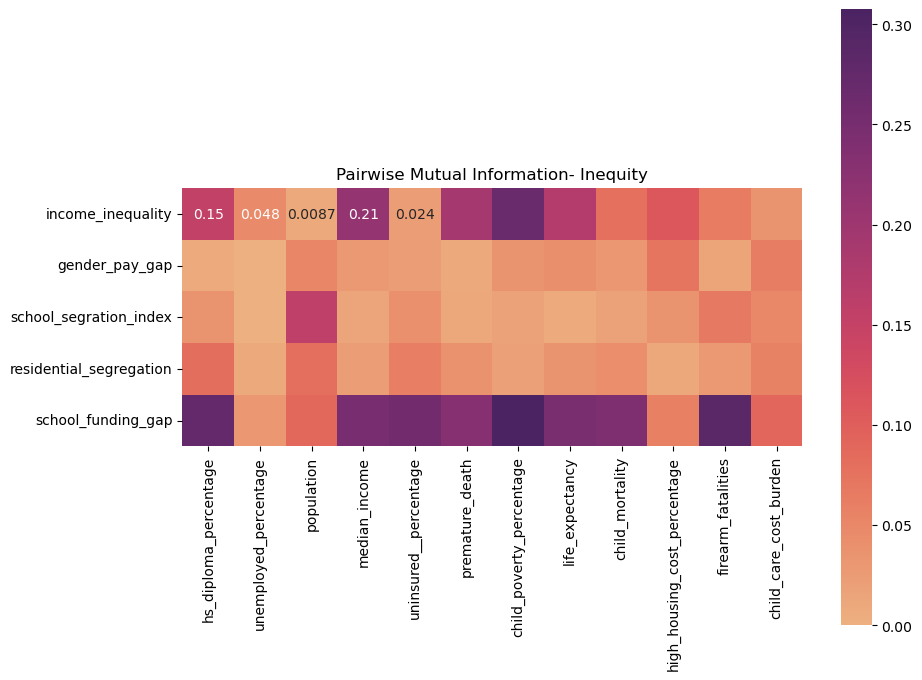

In [251]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutual_info_df, annot=True, cmap='flare', square=True)
plt.title('Pairwise Mutual Information- Inequity')
plt.show()

### Getting most dependent variable pairs

In [252]:
top_var_pairs = mutual_info_df.unstack().sort_values(ascending=False).head(10)
print(top_var_pairs)

child_poverty_percentage  school_funding_gap    0.307498
firearm_fatalities        school_funding_gap    0.285154
hs_diploma_percentage     school_funding_gap    0.275707
child_poverty_percentage  income_inequality     0.265686
uninsured__percentage     school_funding_gap    0.255993
median_income             school_funding_gap    0.248964
life_expectancy           school_funding_gap    0.247403
child_mortality           school_funding_gap    0.240662
premature_death           school_funding_gap    0.231779
median_income             income_inequality     0.212437
dtype: float64


### Data Description

### Correlation and Covariance

In [ ]:
matrix = us_counties_updated.corr(method='spearman', numeric_only=True).round(2)
sns.heatmap(matrix, annot=True)

In [ ]:
sns.pairplot(us_counties, 
    x_vars= ['income_inequality', 'gender_pay_gap', 'school_segration_index', 'residential_segregation','school_funding_gap'],
    y_vars= ['child_mortality', 'child_poverty_percentage','firearm_fatalities', 'life_expectancy', 'median_income', 'premature_death'],
    )     

### Distributions

#### Income Inequality

In [ ]:
inequity_df.hist(figsize=(12,12), layout=(3,3), color='teal', ec='black', sharex=False);

#### Social Indicators

In [ ]:
county_socio_econ = county_socio_econ.drop(columns='population')

In [ ]:
county_socio_econ.hist(figsize=(12,12), layout=(3,3), sharex=False);

In [ ]:

plt.show()

### Regression

In [ ]:
fig, ax = plt.subplots()  
ax.scatter(us_counties_updated['income_inequality'], us_counties_updated['child_mortality'])  
ax.set_xlabel('Income Inequality Index')  
ax.set_ylabel('Child Mortality')  
plt.show()

## Drill down on race

### Pair Plots

In [ ]:
race_anlysis = race_metrics.copy()
race_anlysis = race_anlysis.drop(columns=['county_population', 'population_percentage'])

In [ ]:
sns.pairplot(race_anlysis, hue='race')

In [ ]:
df_test = race_anlysis.merge(inequity_df, on=index)
inequity_df = inequity_df.dropna()

### Comparing distributions between income inequality groupings: 'above_median' and 'below_median'

In [ ]:
print(us_counties_updated['income_inequality'].median())